* https://data.open-power-system-data.org/time_series/
* utc_timestamp 	                   datetime (fmt:%Y-%m-%dT%H%M%SZ) 	    Start of timeperiod in Coordinated Universal Time
* cet_cest_timestamp 	               datetime (fmt:%Y-%m-%dT%H%M%S%z) 	Start of timeperiod in Central European (Summer-) Time
* DE_load_actual_entsoe_transparency 	number 	Total load in Germany in MW as published on ENTSO-E Transparency Platform 	ENTSO-E Transparency
* DE_load_forecast_entsoe_transparency 	number 	Day-ahead load forecast in Germany in MW as published on ENTSO-E Transparency Platform 	ENTSO-E Transparency
* DE_solar_capacity 	                number 	Electrical capacity of solar in Germany in MW 	own calculation based on BNetzA and netztransparenz.de
* DE_solar_generation_actual 	        number 	Actual solar generation in Germany in MW 	ENTSO-E Transparency
* DE_solar_profile 	                    number 	Share of solar capacity producing in Germany 	own calculation based on ENTSO-E Transparency and BNetzA and netztransparenz.de
* DE_wind_capacity 	                    number 	Electrical capacity of wind in Germany in MW 	own calculation based on BNetzA and netztransparenz.de
* DE_wind_generation_actual 	        number 	Actual wind generation in Germany in MW 	own calculation based on ENTSO-E Transparency
* DE_wind_profile 	                    number 	Share of wind capacity producing in Germany 	own calculation based on ENTSO-E Transparency and BNetzA and netztransparenz.de
* DE_wind_offshore_capacity 	        number 	Electrical capacity of wind_offshore in Germany in MW 	own calculation based on BNetzA and netztransparenz.de
* DE_wind_offshore_generation_actual 	number 	Actual wind_offshore generation in Germany in MW 	ENTSO-E Transparency
* DE_wind_offshore_profile 	            number 	Share of wind_offshore capacity producing in Germany 	own calculation based on ENTSO-E Transparency and BNetzA and netztransparenz.de
* DE_wind_onshore_capacity 	            number 	Electrical capacity of wind_onshore in Germany in MW 	own calculation based on BNetzA and netztransparenz.de
* DE_wind_onshore_generation_actual 	number 	Actual wind_onshore generation in Germany in MW 	ENTSO-E Transparency
* DE_wind_onshore_profile

In [1]:
using Statistics
using ImageFiltering
using OffsetArrays

In [2]:
using EEUtils
#open_links()

In [3]:
using PyPlot
#pygui(false)
pygui(:qt5)

:qt5

In [4]:
function simple_damping(y, α)
    n = size(y,1)
    L = Vector{Float64}(undef, n)
    L[1] = y[1]
    for i in 2:n
        L[i] = α*y[i] + (1.0-α)*L[i-1]
    end
    L
end

simple_damping (generic function with 1 method)

[Ruhnau Qvist](https://threadreaderapp.com/thread/1427625795355349004.html)

[Weg frei für Energiespeicher in Deutschland](https://www.pv-magazine.de/unternehmensmeldungen/weg-frei-fuer-energiespeicher-in-deutschland/)

[are-humans-major-cause-global-warming](https://www.ucsusa.org/resources/are-humans-major-cause-global-warming)

[netztransparenz.de](https://www.netztransparenz.de/)

[CO2 pro kWh: Welche ist die klimafreundlichste Energiequelle?](https://www.tech-for-future.de/co2-kwh-strom/#easy-footnote-bottom-4-132)

In [5]:
# EEUtils/time_series_functions.jl
cols_list, cols_dict = get_colums()
dates, values = load_hdf5(cols_dict);

LoadError: UndefVarError: load_hdf5 not defined

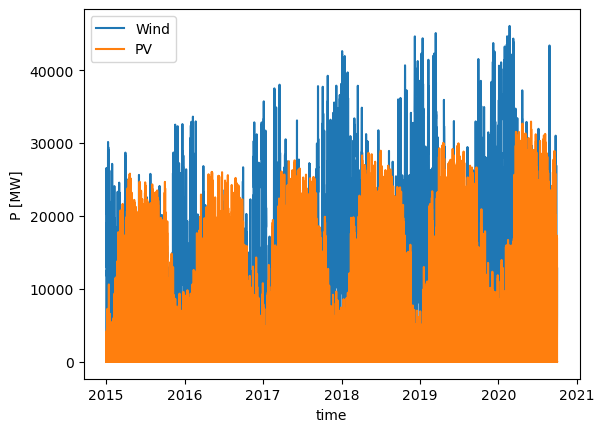

PyObject <matplotlib.legend.Legend object at 0x7f5217e72590>

In [ ]:
plot(dates, values[cols_dict[:DE_wind_generation_actual]], label="Wind")
plot(dates, values[cols_dict[:DE_solar_generation_actual]], label = "PV")
xlabel("time")
ylabel("P [MW]")
legend()

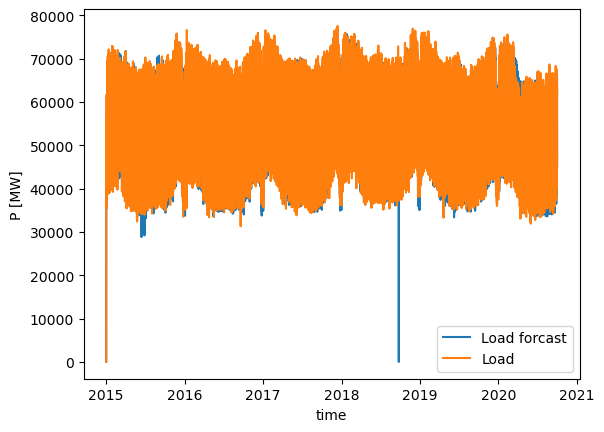

PyObject <matplotlib.legend.Legend object at 0x7f521774c550>

In [ ]:
figure()
plot(dates, values[cols_dict[:DE_load_forecast_entsoe_transparency]], label="Load forcast")
plot(dates, values[cols_dict[:DE_load_actual_entsoe_transparency]], label="Load")
xlabel("time")
ylabel("P [MW]")
legend()

In [ ]:
# load data
EE = values[cols_dict[:DE_wind_generation_actual]] .+ values[cols_dict[:DE_solar_generation_actual]];
LO = values[cols_dict[:DE_load_actual_entsoe_transparency]];

# mean value of laod
LOmean = mean(LO)

# remove outlier
LOc = @. ifelse(LO < 0.3*LOmean, LOmean, LO);

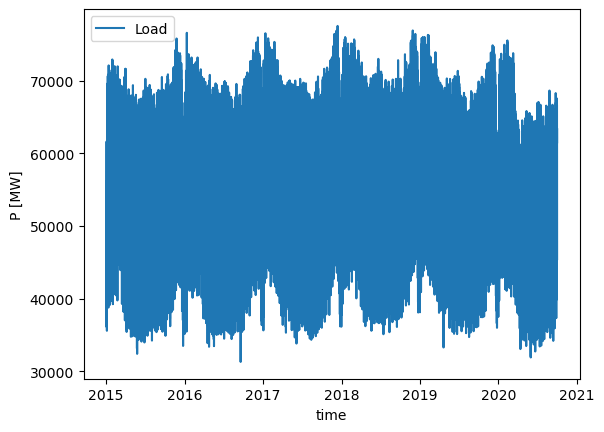

PyObject <matplotlib.legend.Legend object at 0x7f5217403f70>

In [ ]:
# plot load
plot(dates, LOc, label="Load")
xlabel("time")
ylabel("P [MW]")
legend()

In [ ]:
# week average
n = 24*7*2
EEm = moving_average1(EE, n)
LOm = moving_average1(LOc, n);

α = 0.1
L = simple_damping(EE, α);

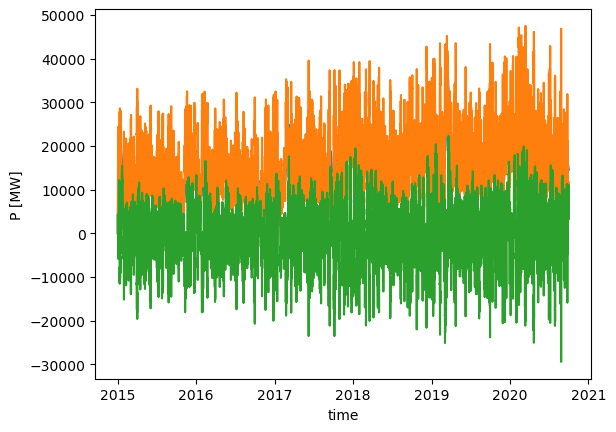

PyObject Text(24.0, 0.5, 'P [MW]')

In [ ]:
plot(dates, EEm, label="EE weakly average")
plot(dates, L, label="EE weakly average")
plot(dates, EEm-L, label="EE weakly average")
#plot(dates, LOm, label="LO weakly average")
xlabel("time")
ylabel("P [MW]")
#legend()

In [ ]:
# week average
n = 24*7
nh = 12*7
nE = size(EE, 1)
nsteps = floor(Int64, nE/n)

EEm2 = []
LOm2 = []
dates2 = []
i0 = 1
while i0 < nE - n
    push!(EEm2, mean(EE[i0:i0+n]))
    push!(LOm2, mean(LOc[i0:i0+n]))
    push!(dates2, dates[i0 + nh])
    i0 = i0 + n
end

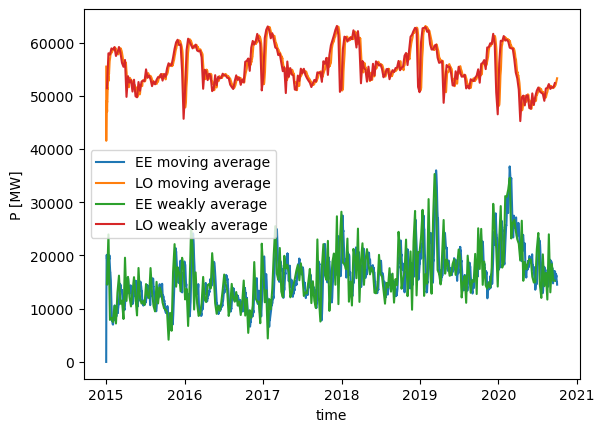

PyObject <matplotlib.legend.Legend object at 0x7f52168ca8c0>

In [ ]:
plot(dates,  EEm, label="EE moving average")
plot(dates,  LOm, label="LO moving average")
plot(dates2, EEm2, label="EE weakly average")
plot(dates2, LOm2, label="LO weakly average")
xlabel("time")
ylabel("P [MW]")
legend()

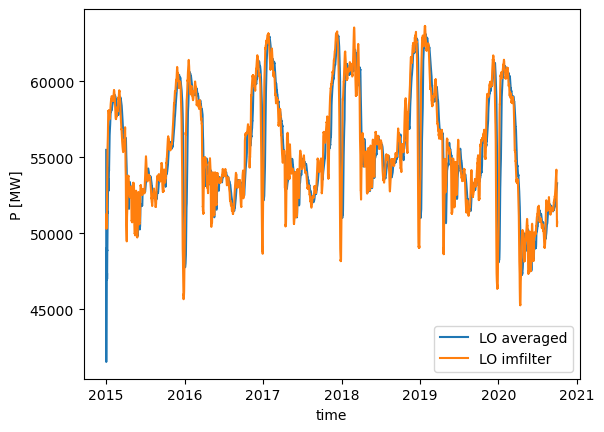

PyObject <matplotlib.legend.Legend object at 0x7f52162071c0>

In [ ]:
nh = Int(floor(n/2))
kernel = OffsetArray(fill(1.0/Float64(n), n), -nh:nh-1);
LOmf = [LOc imfilter(LOc, kernel)][:,2];
plot(dates, LOm, label="LO averaged")
plot(dates, LOmf, label="LO imfilter")
xlabel("time")
ylabel("P [MW]")
legend()

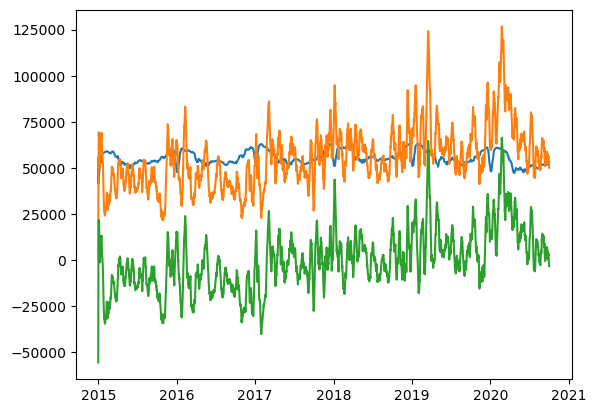

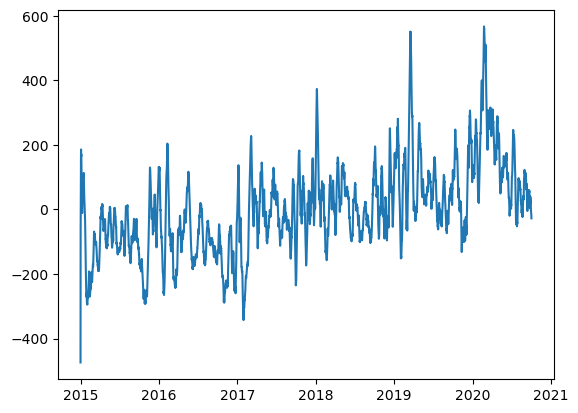

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f52157f0610>

In [ ]:
EEmc = EEm * mean(LO)/mean(EE)

plot(dates, LOm)
plot(dates, EEmc)

diff = (EEmc - LOm) # MW
plot(dates, diff)

figure()
h = 1.0/size(diff,1)
cdiff = cumsum(diff)

#plot(dates, cdiff)

plot(dates, diff * 356*24 * 1.0e-6)


In [ ]:
n  = size(EEmc,1)
nh = Int(floor(n/1))
kernel = OffsetArray(fill(1.0/Float64(2*nh), 2*nh), -nh:nh-1);
EEmc_de = [EEmc ImageFiltering.imfilter(EEmc, kernel)];

EEmc_mean = mean(EEmc)*1.1
EEmc_de_mean = mean(EEmc_de[:,2])
trend = EEmc_de[:,2] * EEmc_mean/EEmc_de_mean

EEmc_detrended = EEmc .- trend .+ EEmc_mean

println(minimum(EEmc_detrended), " ", EEmc_mean)

minimum(EEmc_detrended)/EEmc_mean

1.89809e+04 6.10831e+04


3.10739e-01

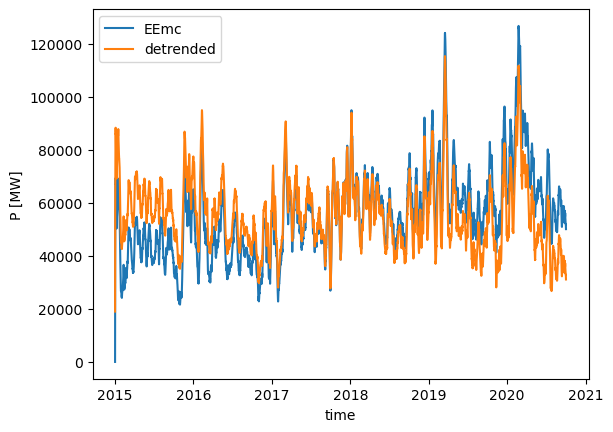

PyObject <matplotlib.legend.Legend object at 0x7f52113635e0>

In [ ]:

plot(dates, EEmc, label="EEmc")
plot(dates, EEmc_detrended, label = "detrended")
xlabel("time")
ylabel("P [MW]")
legend()

sum(diff) = 1.08e+06 [TWh], minimum = -1.52e+01 [TWh]


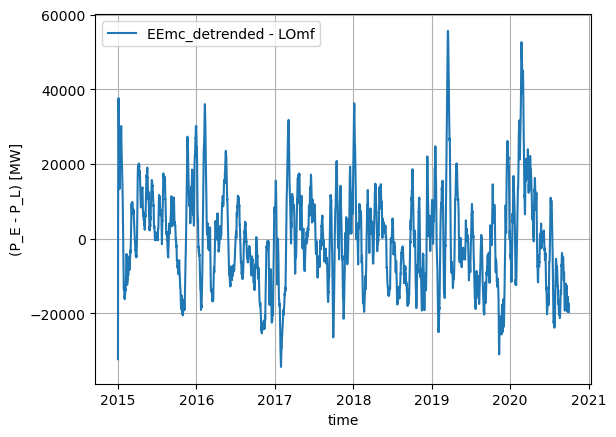

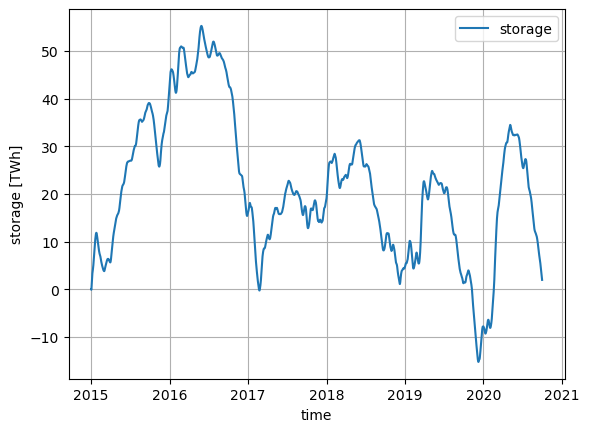

In [ ]:
diff = (EEmc_detrended*1.0 - LOmf) # MW
plot(dates, diff, label="EEmc_detrended - LOmf")
xlabel("time")
ylabel("(P_E - P_L) [MW]")
legend()
grid()
cdiff = cumsum(diff) # MWh
cdiff_TWh = cdiff*1.0e-6 
figure()

plot(dates, cdiff_TWh, label="storage") # TWh
xlabel("time")
ylabel("storage [TWh]")
legend()
grid()
@printf("sum(diff) = %8.2e [TWh], minimum = %8.2e [TWh]\n", sum(cdiff_TWh), minimum(cdiff_TWh))

sum(diff) = 2.24e-14 [TWh]


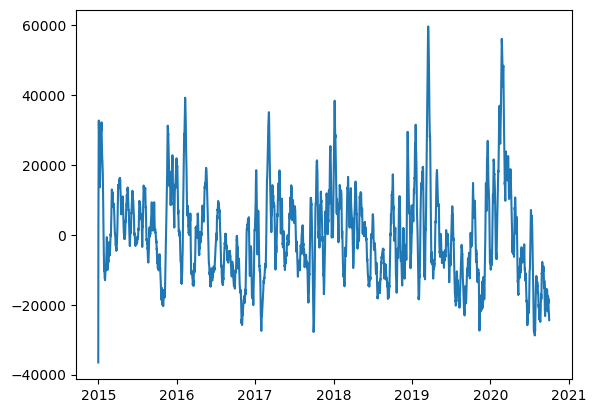

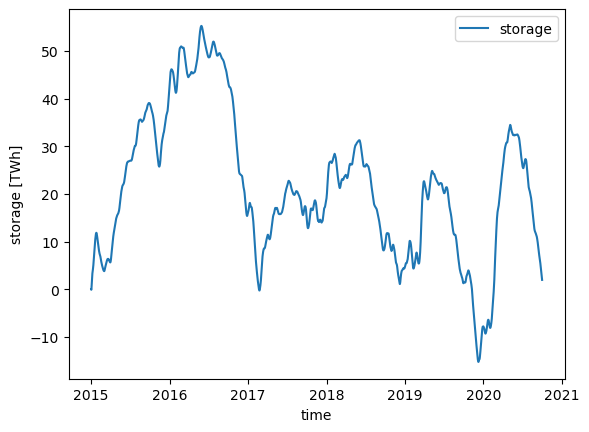

In [ ]:
diff = EEmc_detrended .- mean(EEmc_detrended)
plot(dates,diff)

figure()
plot(dates, cdiff*1.0e-6, label="storage") # TWh
xlabel("time")
ylabel("storage [TWh]")
legend()
@printf("sum(diff) = %8.2e [TWh]\n", sum(diff)*1.0e-6);

* https://www.sma-sunny.com/wie-viel-speicher-braucht-die-energiewende/

<img src="fig/Speicherbedarf-PV+Wind-1.png" alt="drawing" width="800"/>
 
* Ziegler, Storage Requirements and Costs of Shaping Renewable Energy Toward Grid Decarbonization

<img src="fig/Ziegler-Storage-Requirements.png" alt="drawing" width="800"/>


* Traber, Erneuerbare Energien für Deutschland bis 2030 Klimaschutz – Versorgungssicherheit – Wirtschaftlichkeit

<img src="fig/Traber-Formel.png" alt="drawing" width="800"/>


* Ruhnau, Storage requirements in a 100% renewable electricity system: Extreme events and inter-annual variability

    * /home/wester/ProjectsP/Jupyter/Climate-Energy/Literatur/Storage/Ruhnau-and-Qvist-2021-Storage-requirements-in-a-100-renewable-electricity-system-EconStor.pdf

<img src="fig/Ruhnau.png" alt="drawing" width="800"/>

In [ ]:
figname = "Ruhnau.png"
show_figure(figname)
pdfname = "Ruhnau-and-Qvist-2021-Storage-requirements-in-a-100-renewable-electricity-system-EconStor.pdf"
open_pdf(pdfname)

 <img src="Ruhnau.png" alt="drawing" width="800"/>

Process(`okular /home/wester/ProjectsP/Jupyter/Climate-Energy/Literatur/Top/Ruhnau-and-Qvist-2021-Storage-requirements-in-a-100-renewable-electricity-system-EconStor.pdf`, ProcessExited(0))

In [ ]:
root = "/home/wester/Literatur/Zotero/Privat/storage"
fname = ".zotero-ft-cache"
pattern= "ENTSO"
find_files_content(root, fname, pattern)

33-element Vector{Any}:
 (1, "/home/wester/Literatur/Zotero/Privat/storage/4MXRMDWS/Ringkjøb et al_2018_A review of modelling tools for energy and electricity systems with large.pdf")
 (5, "/home/wester/Literatur/Zotero/Privat/storage/5EIRKV7M/TE_LCA_Update-June.pdf")
 (1, "/home/wester/Literatur/Zotero/Privat/storage/6PGGMLYC/Agora Energiewende_2022_Klimaneutrales Stromsystem 2035.pdf")
 (1, "/home/wester/Literatur/Zotero/Privat/storage/8KAHHLQF/Sterchele et al. - Studie Wege zu einem klimaneutralen Energiesystem.pdf")
 (112, "/home/wester/Literatur/Zotero/Privat/storage/C8G57S7N/ENTSO-E_Market_Report_2020.pdf")
 (2, "/home/wester/Literatur/Zotero/Privat/storage/DINKCMHZ/ISE_2018_Optimierungsmodell REMod-D.pdf")
 (2, "/home/wester/Literatur/Zotero/Privat/storage/DJHVN8MV/Tröndle et al. - 2020 - Trade-Offs between Geographic Scale, Cost, and Inf.pdf")
 (2, "/home/wester/Literatur/Zotero/Privat/storage/ETCSDCJ5/Ruhnau and Qvist - Storage requirements in a 100% renewable electrici.pdf")
